In [7]:
import numpy as np
import matplotlib.pyplot as plt
import pywt

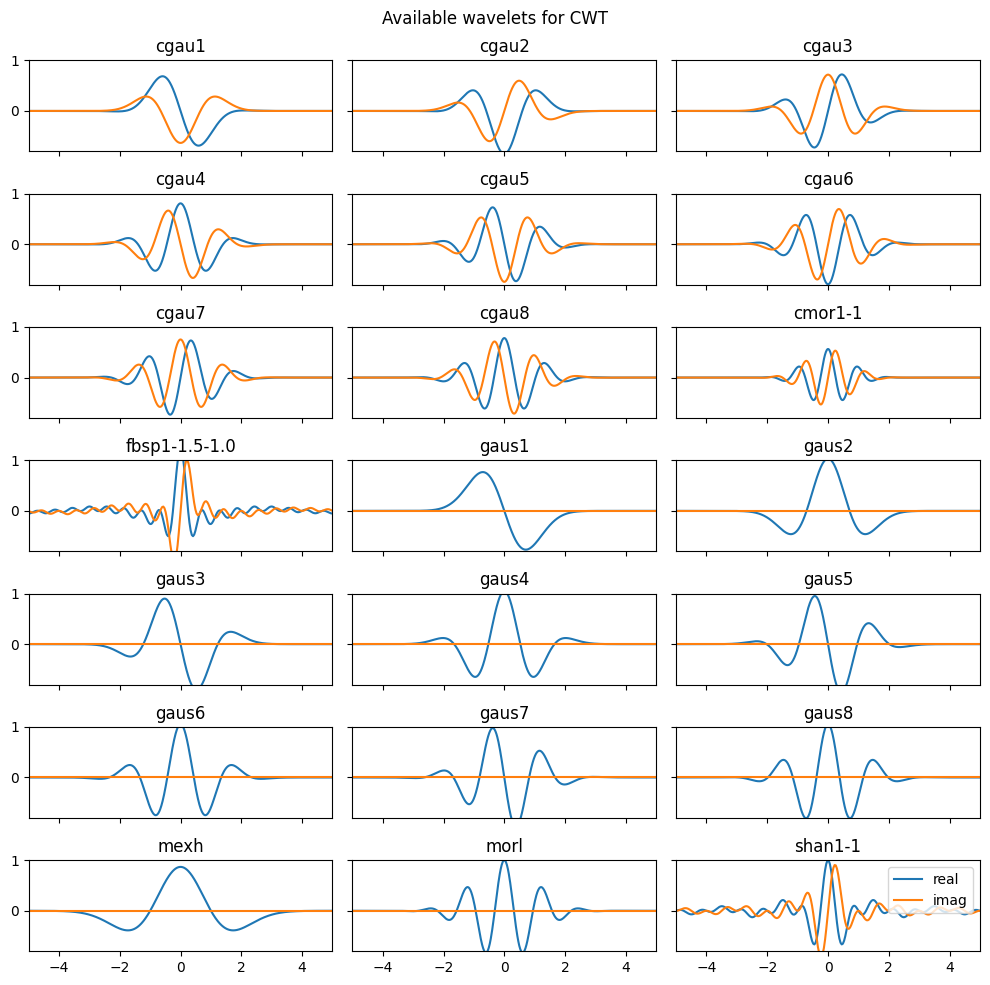

In [2]:
wavlist = pywt.wavelist(kind="continuous")
cols = 3
rows = (len(wavlist) + cols - 1) // cols
fig, axs = plt.subplots(rows, cols, figsize=(10, 10),
                        sharex=True, sharey=True)
for ax, wavelet in zip(axs.flatten(), wavlist):
    # A few wavelet families require parameters in the string name
    if wavelet in ['cmor', 'shan']:
        wavelet += '1-1'
    elif wavelet == 'fbsp':
        wavelet += '1-1.5-1.0'

    [psi, x] = pywt.ContinuousWavelet(wavelet).wavefun(10)
    ax.plot(x, np.real(psi), label="real")
    ax.plot(x, np.imag(psi), label="imag")
    ax.set_title(wavelet)
    ax.set_xlim([-5, 5])
    ax.set_ylim([-0.8, 1])

ax.legend(loc="upper right")
plt.suptitle("Available wavelets for CWT")
plt.tight_layout()
plt.show()

In [11]:
import mne
import pandas as pd
import numpy as np

def file_to_DataDrame(path):
    """
    This function takes in a file path and returns a dataframe with the data and the target values
    format:
        Fc5	        Fc3	        Fc1	        ...	Oz	        O2	        Iz	        target
    0	-0.000046	-0.000041	-0.000032	...	0.000040	0.000108	0.000055	T0
    1	-0.000054	-0.000048	-0.000034	...	0.000064	0.000114	0.000074	T0
    ...
    """

    reader = mne.io.read_raw_edf(path, preload=True)
    annotations = reader.annotations  # get the values of the annotations
    codes = annotations.description  # get the codes from the annotations

    df = pd.DataFrame(
        reader.get_data().T,
        columns=[channel.replace(".", "") for channel in reader.ch_names],
    )  # transpose the data to get the right shape
    df = df[~(df == 0).all(axis=1)]  # remove rows with all zeros
    timeArray = np.array(
        [round(x, 10) for x in np.arange(0, len(df) / 160, 0.00625)]
    )  # create an array of time values

    codeArray = []
    counter = 0
    for timeVal in timeArray:
        if (
            timeVal in annotations.onset
        ):  # if the time value is in the onset array, add the corresponding code to the codeArray
            counter += 1
        code_of_target = int(
            codes[counter - 1].replace("T", "")
        )  # convert T0 to 0, T1 to 1, etc
        codeArray.append(code_of_target)

    df["target"] = np.array(codeArray).T
    return df

def all_exp_to_array(num_person, choose_num_of_exp):
    """
    num_person: int renage(1,109)
    choose_num_of_exp: list of int[3,4,7,8,11,12]

    return: all_meseurments, all_targets
    """
   

    all_meseurments = np.zeros((len(choose_num_of_exp),20000,64))
    all_targets = np.zeros((len(choose_num_of_exp),20000))
    for i in range(len(choose_num_of_exp)):
        fileName = f"files/S{num_person:03d}/S{num_person:03d}R{choose_num_of_exp[i]:02d}.edf"
        df = file_to_DataDrame(fileName)
        for j in range(20000):
            if j >= len(df):
                all_meseurments[i][j] = np.zeros(64) 
                all_targets[i][j] = np.nan
            else:
                all_meseurments[i][j] = df.iloc[j].values[:-1]
                all_targets[i][j] = df.iloc[j].values[-1]
    return all_meseurments, all_targets
                
      
          

In [12]:
exps = [3,4,7,8,11,12]
num_person = 1
all_meseurments, all_targets = all_exp_to_array(num_person, exps)

Extracting EDF parameters from /home/daniel/repos/Decoding_of_EEG/files/S001/S001R03.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19999  =      0.000 ...   124.994 secs...
Extracting EDF parameters from /home/daniel/repos/Decoding_of_EEG/files/S001/S001R04.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19999  =      0.000 ...   124.994 secs...
Extracting EDF parameters from /home/daniel/repos/Decoding_of_EEG/files/S001/S001R07.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19999  =      0.000 ...   124.994 secs...
Extracting EDF parameters from /home/daniel/repos/Decoding_of_EEG/files/S001/S001R08.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19999  =      0.000 ...   124.994 secs...
Extracting EDF parameters from /home/daniel/repos/Decoding_of_EEG/files/S001

In [131]:
exps = [3,4]
num_person = 1
df= file_to_DataDrame(f"files/S{num_person:03d}/S{num_person:03d}R{exps[0]:02d}.edf")
fc5 = df["Fc5"][0:4000]


Extracting EDF parameters from /home/daniel/repos/Decoding_of_EEG/files/S001/S001R03.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19999  =      0.000 ...   124.994 secs...


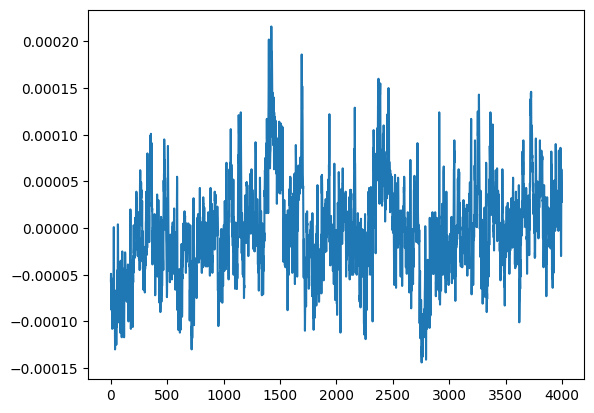

In [132]:
#polot the dft of fc5
plt.plot(fc5)

In [141]:
# notrmalize the data 0 to 1
fc5 = np.interp(fc5, (fc5.min(), fc5.max()), (-1, +1))

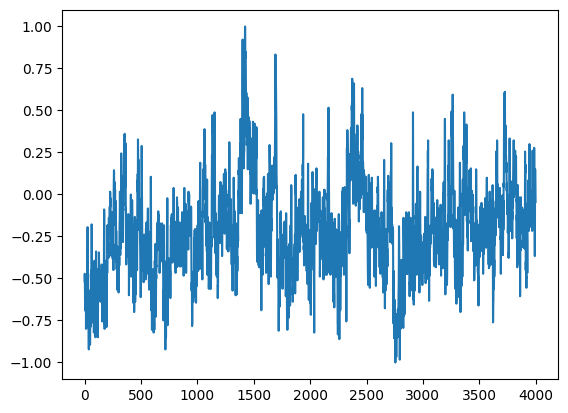

In [142]:
#polot the dft of fc5
plt.plot(fc5)

In [143]:
# Start T0 or T1 or T2 
def index_of_TX(df):
    key = 0
    dict_TX_index = {key: [df['target'][0], 0] }
    current_TX = df['target'][0]
    for i in range(len(df['target'])):
        if df['target'][i] != current_TX:
            key += 1
            dict_TX_index[key] = [df['target'][i], i]
            current_TX = df['target'][i]
 
    return dict_TX_index

# cat dict_TX_index to 4000 stampls
dict_TX = index_of_TX(df)



In [144]:
wavelet = "cmor1.5-1.0"
cwtmatr, freqs = pywt.cwt(fc5, np.arange(1, 128), wavelet)

In [169]:
indexs = index_of_TX(df)
xT0=[]
xT1=[]
xT2=[]

for i in range(0,len(indexs)):
    if indexs[i][0] == 0 and len(xT0) <= 3:
        xT0.append(indexs[i][1]/160)      
    elif indexs[i][0] == 1 and len(xT0) <= 3:
        xT1.append(indexs[i][1]/160)
    elif indexs[i][0] == 2 and len(xT0) <= 3:
        xT2.append(indexs[i][1]/160)

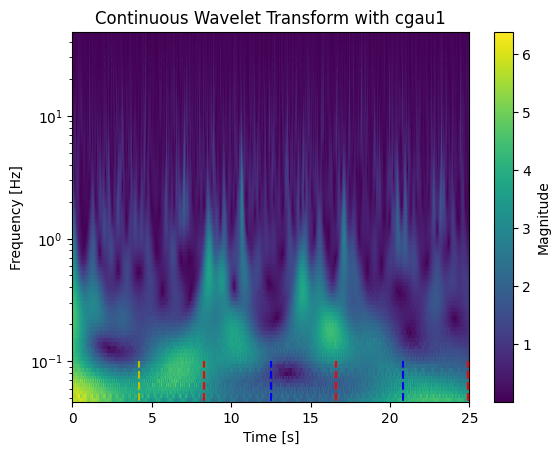

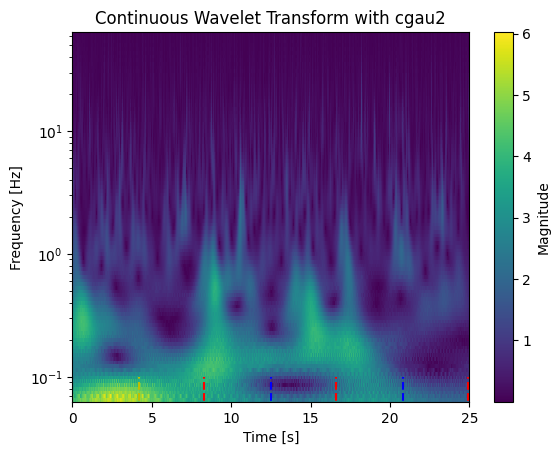

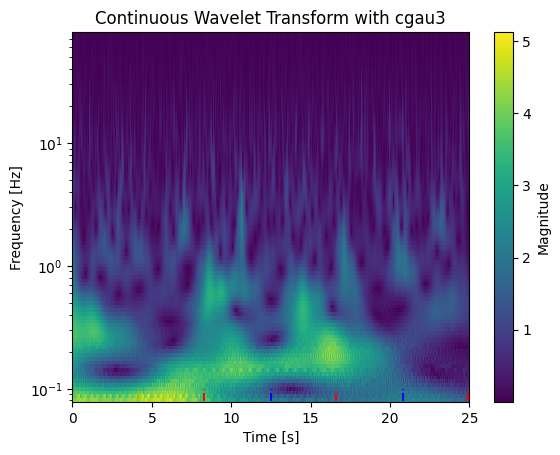

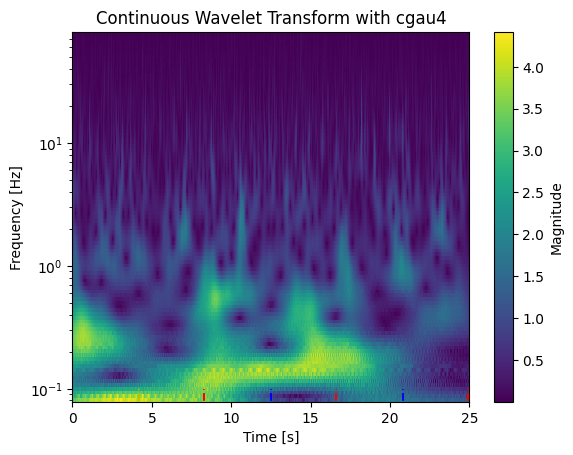

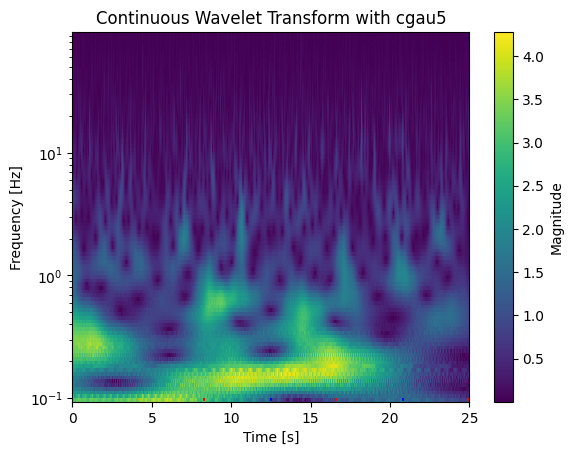

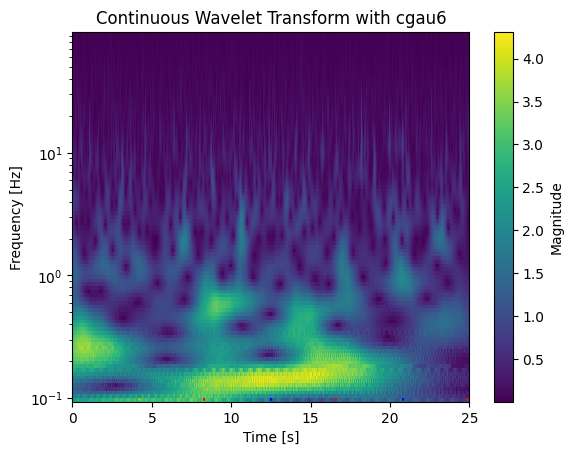

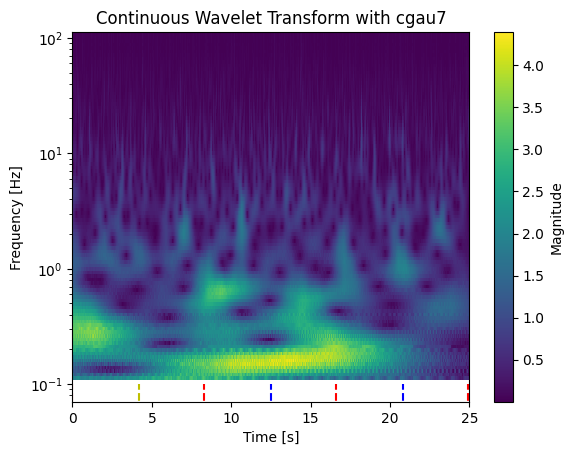

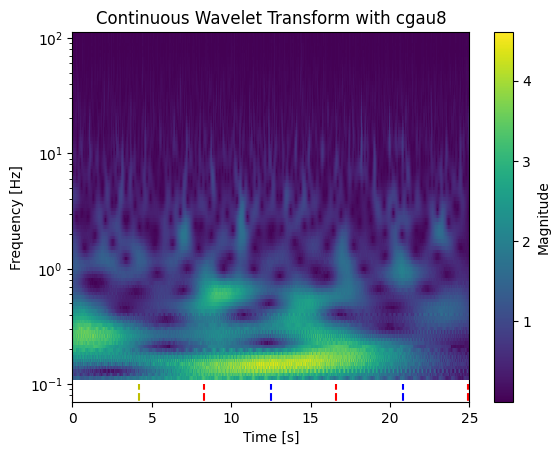

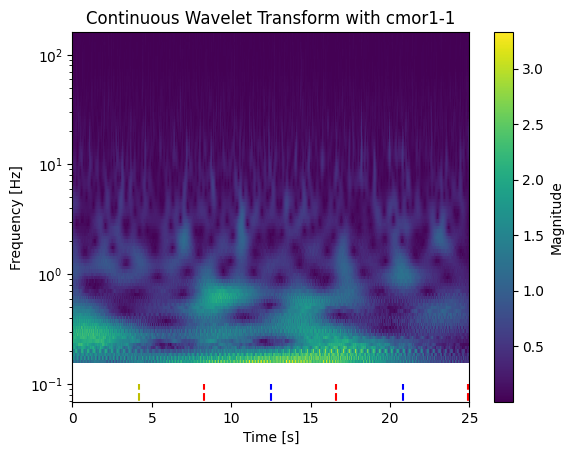

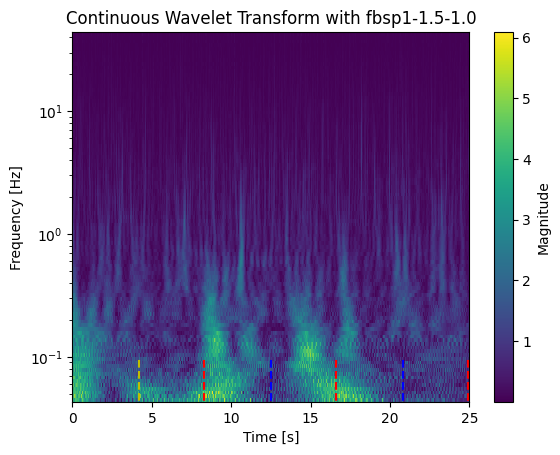

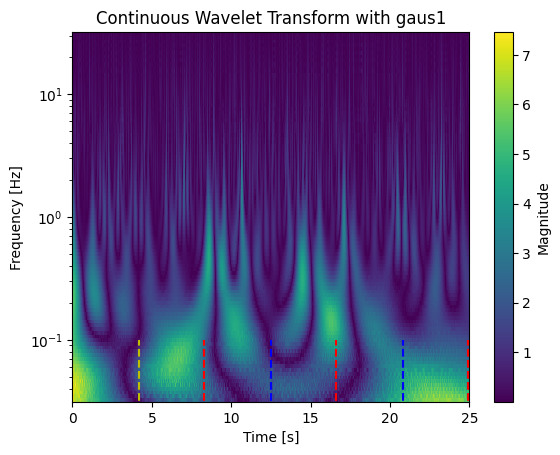

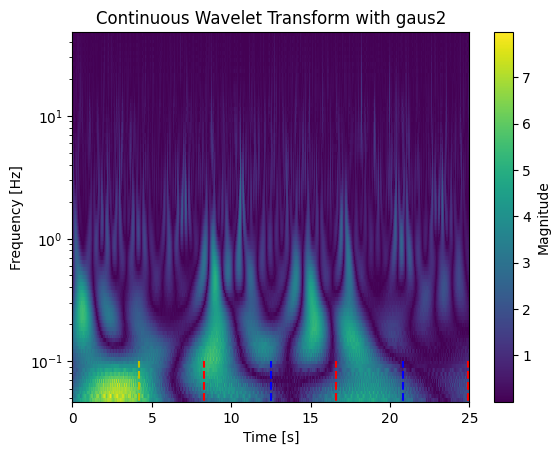

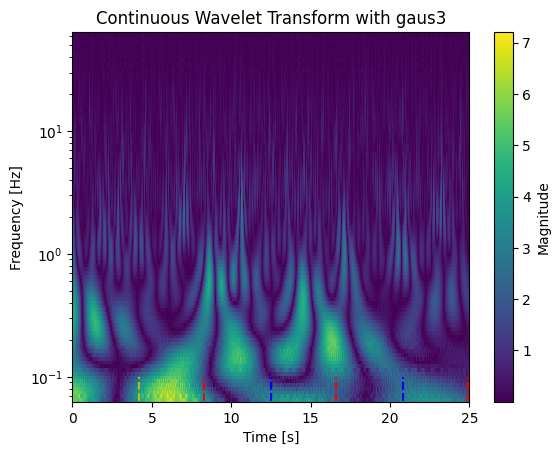

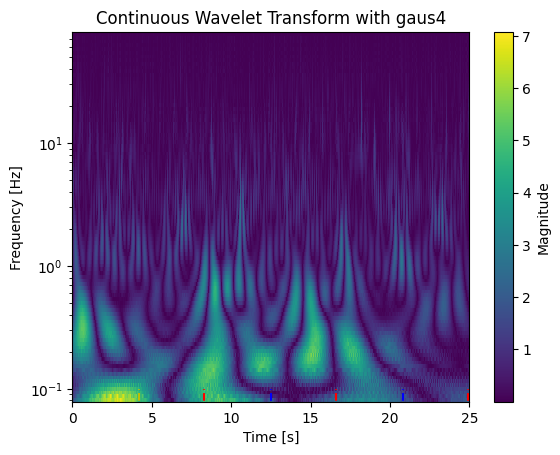

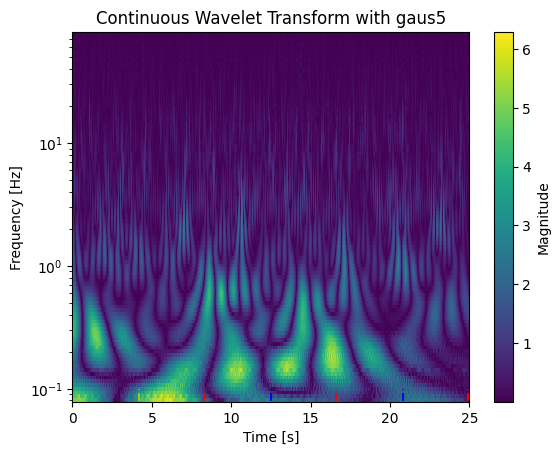

In [170]:

time = np.linspace(0, 4000 / 160, 4000)
# Przykładowy sygnał
signal = fc5

# Parametry transformacji falkowej
widths = np.geomspace(1, 1024, num=100)
sampling_period = np.diff(time).mean()
wavlist = pywt.wavelist(kind="continuous")                       
for  wavelet in wavlist:
    # A few wavelet families require parameters in the string name
    if wavelet in ['cmor', 'shan']:
        wavelet += '1-1'
    elif wavelet == 'fbsp':
        wavelet += '1-1.5-1.0' 
    # Przeprowadzenie transformacji falkowej
    cwtmatr, freqs = pywt.cwt(signal, widths, wavelet, sampling_period=sampling_period)
    cwtmatr = np.abs(cwtmatr[:-1, :-1])

    # Wyświetlenie wyników
    # plot result using matplotlib's pcolormesh (image with annoted axes)
    plt.figure()
    #set pcolormesh
    plt.pcolormesh(time, freqs, cwtmatr)
    #add vertical lines
    plt.vlines(x=xT0, ymin=0, ymax=10, color='r',label='T0',linestyles='dashed')
    plt.vlines(x=xT1, ymin=0, ymax=10, color='b',label='T1',linestyles='dashed')
    plt.vlines(x=xT2, ymin=0, ymax=10, color='y',label='T2', linestyles='dashed')
    #set yscale to logarithmic
    plt.yscale('log')
    #set labels
    plt.ylabel('Frequency [Hz]')
    plt.xlabel('Time [s]')
    plt.title(f'Continuous Wavelet Transform with {wavelet}')
    #show colorbar
    plt.colorbar(label='Magnitude')
    plt.show()

In [160]:
wavlist

['cgau1',
 'cgau2',
 'cgau3',
 'cgau4',
 'cgau5',
 'cgau6',
 'cgau7',
 'cgau8',
 'cmor',
 'fbsp',
 'gaus1',
 'gaus2',
 'gaus3',
 'gaus4',
 'gaus5',
 'gaus6',
 'gaus7',
 'gaus8',
 'mexh',
 'morl',
 'shan']